# Adjusting pmf to 2 (default value 1)
# Adjusting ec50 both lumefantrine and artemisinin 
# Adjusting pmax for ONLY for lumefantrine 0.9599

### ec50 lum = 12 (default 63)
### ec50 art = 0.8 (default 0.1)
### pmax lum = 0.9599 (default 0.9995)
### pmax art = 0.9 (default 0.9997)

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle

In [40]:
command_100_patients = ["/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk", "--AL", "-n", "100", "--pmf",  "2", "--ec50_lum", "12", "--ec50_art", "0.8", "--pmax_lum", "0.9599", "--pmax_art", "0.9"]

output_100_patients = subprocess.run(command_100_patients, capture_output=True, text=True)
lines_100_patients = output_100_patients.stdout.splitlines()
df_100_patients = pd.DataFrame([line.split(',') for line in lines_100_patients], columns=["PID","HOUR","COMP2CONC_ART","COMP2CONC_LUM","PARASITEDENSITY"])
df_100_patients = df_100_patients.iloc[1:]
df_100_patients = df_100_patients.apply(pd.to_numeric, errors='coerce')
    

In [15]:
#Saving the main dataframe to a pickle file
#pickle.dump(df_100_patients, open('df_100_patients_95.efficacy_pmax_lum.py.obj', 'wb')) 
#df_100_patients.to_csv('df_100_patients_py_95.efficacy_pmax_lum.csv', index=False, quoting= False)

In [10]:
#Loading the main dataframe from a pickle file
df_100_patients = pickle.load(open('df_100_patients_95.efficacy_pmax_lum.py.obj', 'rb'))

In [11]:
#Converting 0s to 0.0001 to avoid log(0) error
#df_100_patients['PARASITEDENSITY'] = df_100_patients['PARASITEDENSITY'].replace(0.000, 0.0001)
#Creating new column with log(parasite density)
df_100_patients['LOG_PARASITEDENSITY'] = np.log10(df_100_patients['PARASITEDENSITY'] + 0.00001)

In [12]:
#Getting number of patients with treatment failure
df_100_patients_day28_failed = df_100_patients[(df_100_patients['PARASITEDENSITY'] >= 10) & (df_100_patients['HOUR'] == 671.0)]
df_100_patients_day28_failed_pids = df_100_patients_day28_failed['PID'].unique().tolist()
df_100_patients_day28_failed_pids = np.array(df_100_patients_day28_failed_pids)
print(df_100_patients_day28_failed['PID'].unique().tolist())
len(df_100_patients_day28_failed['PID'].unique().tolist())


[5, 7, 54, 62, 82]


5

In [13]:
#Assigning patients as failred/cleared based on day 28 parasite density
df_100_patients['STATUS'] = np.where(df_100_patients['PID'].isin(df_100_patients_day28_failed_pids), 'Failed', 'Cleared')

#Separating patients into failed and cleared
df_100_patients_cleared = df_100_patients[df_100_patients['STATUS'] == 'Cleared']
df_100_patients_failed = df_100_patients[df_100_patients['STATUS'] == 'Failed']

In [14]:
#Saving the cleared and failed dataframes to a pickle file
#pickle.dump(df_100_patients_cleared, open('df_100_patients_95.efficacy_pmax_lum.cleared_py.obj', 'wb'))
#pickle.dump(df_100_patients_failed, open('df_100_patients_95.efficacy_pmax_lum.failed_py.obj', 'wb'))

#Also outputting the cleared and failed dataframes to csv files
#df_100_patients_cleared.to_csv('df_100_patients_95.efficacy_pmax_lum.cleared.csv', index=False, quoting= False)
#df_100_patients_failed.to_csv('df_100_patients_95.efficacy_pmax_lum.failed.csv', index=False, quoting= False)

In [67]:
df_100_patients_cleared_wide = df_100_patients_cleared.pivot(index="HOUR", columns="PID", values="PARASITEDENSITY")
df_100_patients_failed_wide = df_100_patients_failed.pivot(index="HOUR", columns="PID", values="PARASITEDENSITY")

In [68]:

# Calculate the median, 25th percentile, and 75th percentile for cleared and failed
median_parasite_density_cleared = df_100_patients_cleared_wide.median(axis=1)
perc_05_parasite_density_cleared = df_100_patients_cleared_wide.quantile(0.05,axis=1)
perc_95_parasite_density_cleared = df_100_patients_cleared_wide.quantile(0.95,axis=1)

median_parasite_density_failed = df_100_patients_failed_wide.median(axis=1)
perc_05_parasite_density_failed = df_100_patients_failed_wide.quantile(0.05,axis=1)
perc_95_parasite_density_failed = df_100_patients_failed_wide.quantile(0.95,axis=1)


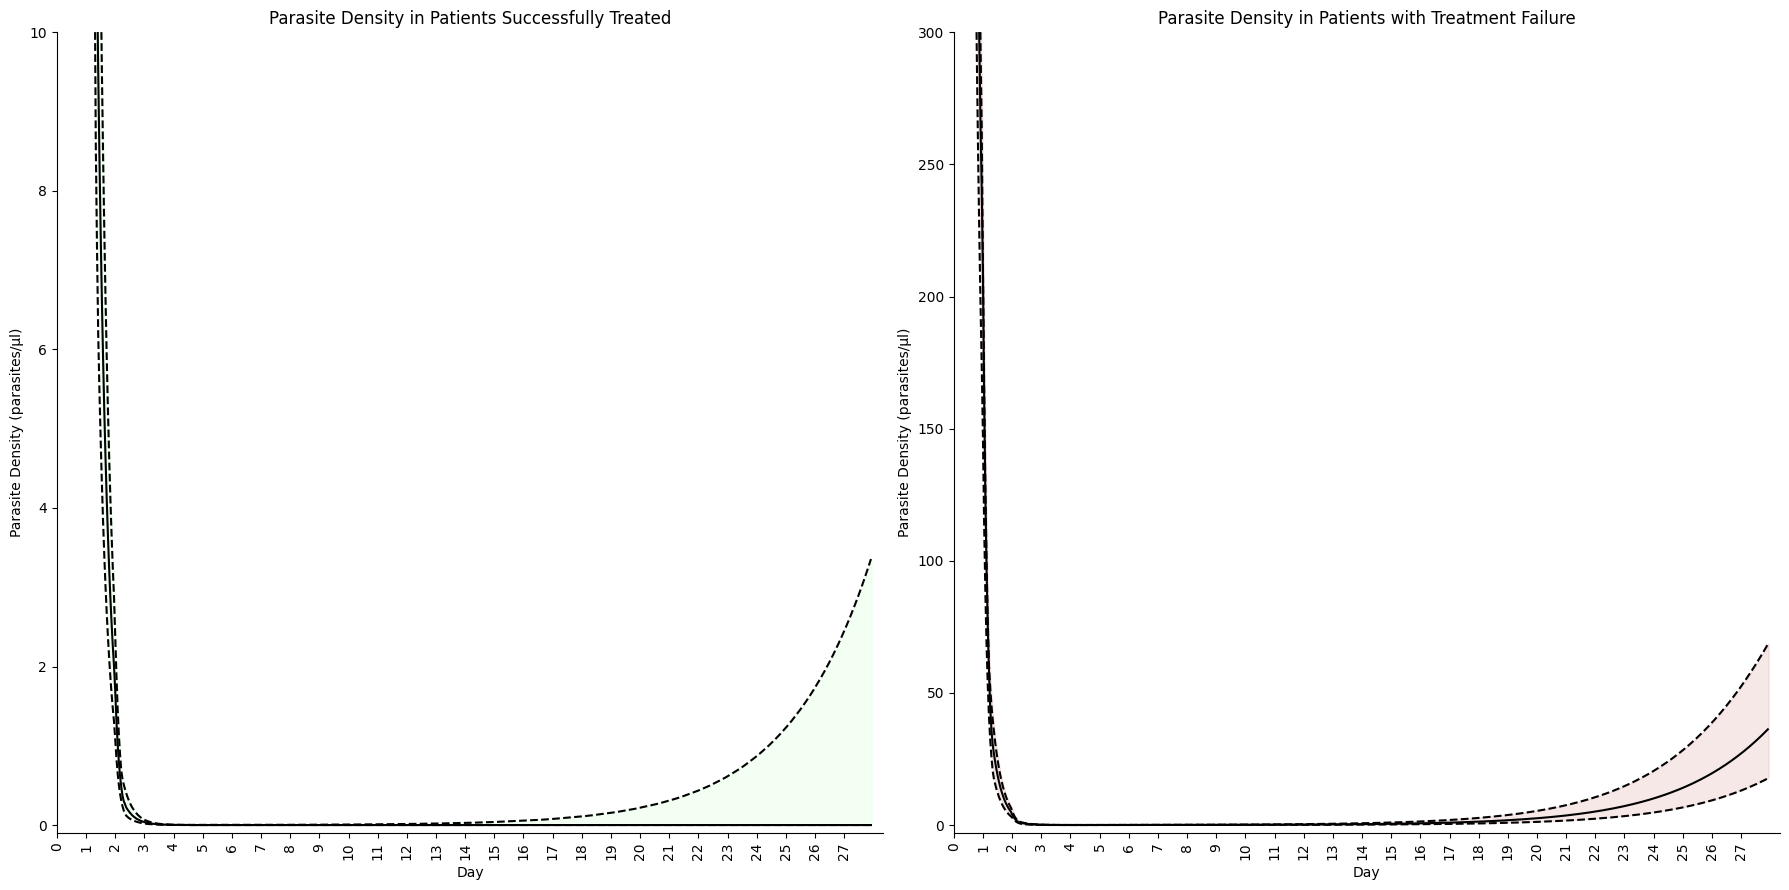

In [69]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_100_patients['HOUR'], y= median_parasite_density_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_05_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_95_parasite_density_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared, perc_95_parasite_density_cleared, color="#98FF98", alpha=0.1)

sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-0.1, 10)
#Set x-axis label
ax1.set_xlabel('Day')
#Set y-axis label
ax1.set_ylabel('Parasite Density (parasites/μl)')
tick_positions = range(0, int(df_100_patients_failed['HOUR'].max()) + 1, 24)
ax1.set_xticks(tick_positions)
# Convert hour ticks to days
tick_labels = [int(hour / 24) for hour in tick_positions]
ax1.set_xticklabels(tick_labels, rotation=90)
#Plot title
ax1.set_title('Parasite Density in Patients Successfully Treated')


ax2 = sns.lineplot(ax=axes[1], x= df_100_patients['HOUR'], y= median_parasite_density_failed, color="black")
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_05_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_95_parasite_density_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed, perc_95_parasite_density_failed, color="#B22222", alpha=0.1)

sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
ax2.set_ylim(-3, 300)
#Set x-axis label
ax2.set_xlabel('Day')
#Set y-axis label
ax2.set_ylabel('Parasite Density (parasites/μl)')
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, rotation=90)
#Plot title
ax2.set_title('Parasite Density in Patients with Treatment Failure')



plt.tight_layout()
plt.show()

In [70]:
df_100_patients_cleared_wide_log = df_100_patients_cleared.pivot(index="HOUR", columns="PID", values="LOG_PARASITEDENSITY")
df_100_patients_failed_wide_log = df_100_patients_failed.pivot(index="HOUR", columns="PID", values="LOG_PARASITEDENSITY")

In [72]:

# Calculate the median, 25th percentile, and 75th percentile for cleared and failed using log parasite density
median_parasite_density_cleared_log = df_100_patients_cleared_wide_log.median(axis=1)
perc_05_parasite_density_cleared_log = df_100_patients_cleared_wide_log.quantile(0.05,axis=1)
perc_95_parasite_density_cleared_log = df_100_patients_cleared_wide_log.quantile(0.95,axis=1)

median_parasite_density_failed_log = df_100_patients_failed_wide_log.median(axis=1)
perc_05_parasite_density_failed_log = df_100_patients_failed_wide_log.quantile(0.05,axis=1)
perc_95_parasite_density_failed_log = df_100_patients_failed_wide_log.quantile(0.95,axis=1)

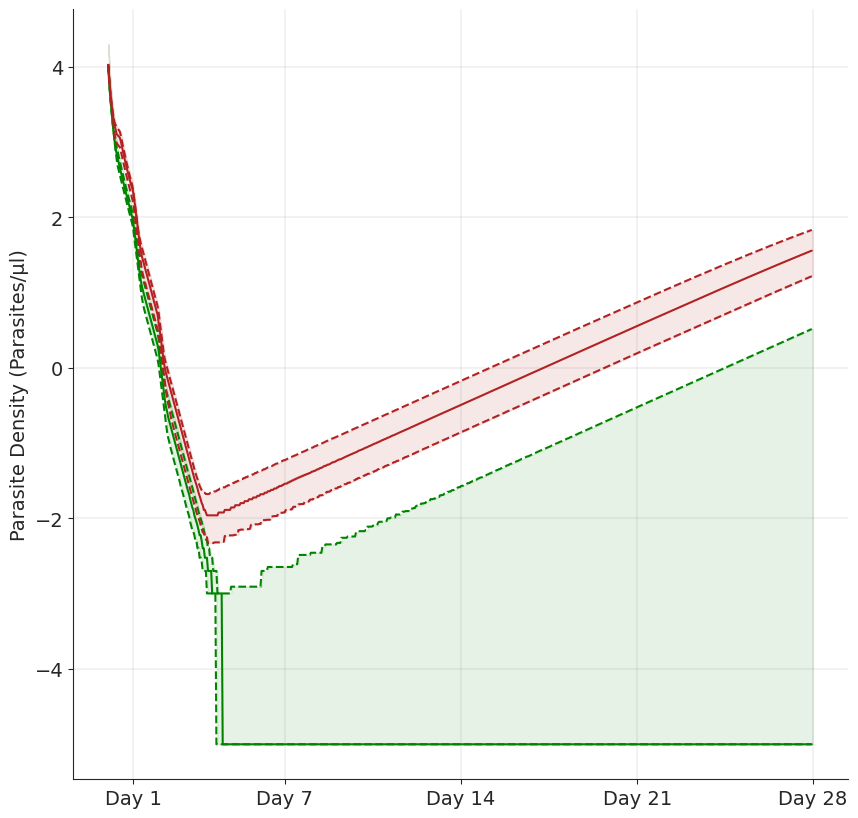

In [79]:
#Plot Parasitemia 
#Creating a spaghetti plot using seaborn
plt.figure(figsize=(10, 10))
sns.set_style("ticks")

palette_cleared = ["#e5ffe5","#cbffcb","#b2ffb2","#98FF98","#7fff7f","#65ff65","#4cff4c"]
palette_failed = ["#ffcbcb","#ff9797","#ff6464","#ff3232","#ff0000","#cb0000","#970000"] 
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_cleared, 83), data=df_100_patients_cleared, legend=False)
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_failed, 17), data=df_100_patients_failed, legend=False)

sns.lineplot(x= df_100_patients['HOUR'], y= median_parasite_density_cleared_log, color="#008400")
sns.lineplot(x=df_100_patients['HOUR'], y=perc_05_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(x=df_100_patients['HOUR'], y=perc_95_parasite_density_cleared_log, color="#008400", linestyle='--')
plt.fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)

sns.lineplot(x= df_100_patients['HOUR'], y= median_parasite_density_failed_log, color="#B22222")
sns.lineplot(x=df_100_patients['HOUR'], y=perc_05_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(x=df_100_patients['HOUR'], y=perc_95_parasite_density_failed_log, color="#B22222", linestyle='--')
plt.fill_between(np.arange(672),perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)


sns.despine()

plt.grid(visible=True, which='major', color='black', linewidth=0.075)
plt.grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set tick positions and labels for specific days
tick_positions = [24.0, 168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['Day 1', 'Day 7', 'Day 14', 'Day 21','Day 28']
plt.xticks(tick_positions, tick_labels)


ax1.set_ylim(-0.1, 20000)
plt.xlabel('')
plt.ylabel('Parasite Density (Parasites/μl)')

plt.savefig('log_parasitemia_median_95.efficacy.v2.png')
plt.show()

In [75]:
perc_25_parasite_density_cleared = df_100_patients_cleared_wide.quantile(0.25,axis=1)
perc_75_parasite_density_cleared = df_100_patients_cleared_wide.quantile(0.75,axis=1)

perc_25_parasite_density_failed = df_100_patients_failed_wide.quantile(0.25,axis=1)
perc_75_parasite_density_failed = df_100_patients_failed_wide.quantile(0.75,axis=1)

perc_25_parasite_density_cleared_log = df_100_patients_cleared_wide_log.quantile(0.25,axis=1)
perc_75_parasite_density_cleared_log = df_100_patients_cleared_wide_log.quantile(0.75,axis=1)

perc_25_parasite_density_failed_log = df_100_patients_failed_wide_log.quantile(0.25,axis=1)
perc_75_parasite_density_failed_log = df_100_patients_failed_wide_log.quantile(0.75,axis=1)

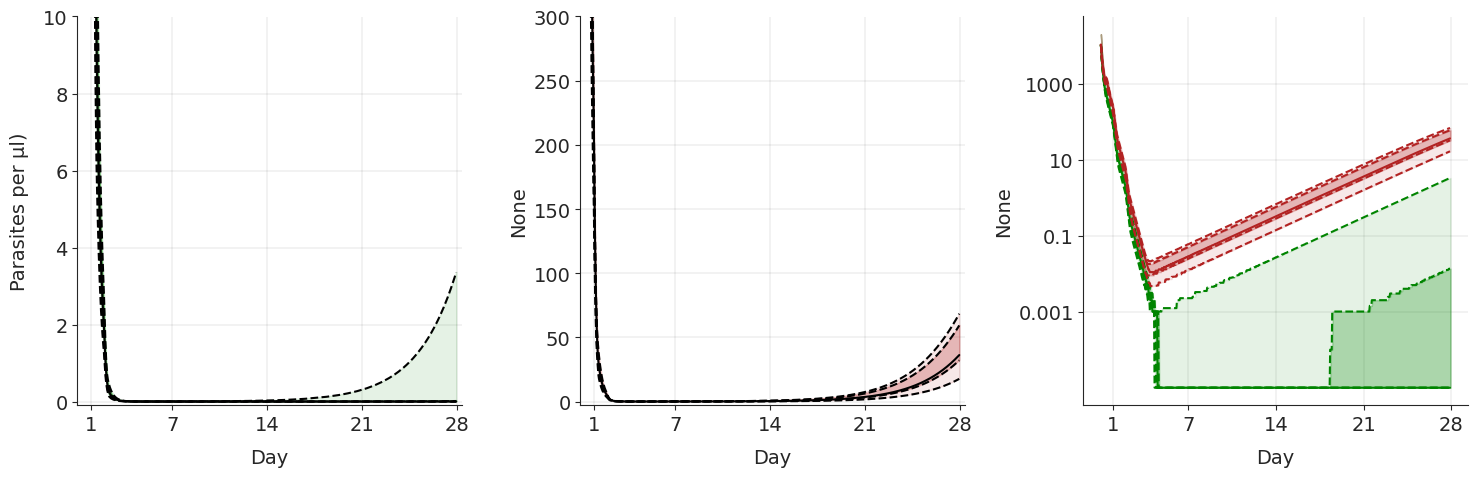

In [87]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_100_patients['HOUR'], y= median_parasite_density_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_05_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_25_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_75_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_100_patients['HOUR'], y=perc_95_parasite_density_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared, perc_75_parasite_density_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared, perc_95_parasite_density_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-0.1, 10)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Parasites per μl)', labelpad = 10)
# Set tick positions and labels for specific days
tick_positions = [24.0,168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_100_patients['HOUR'], y= median_parasite_density_failed, color="black")
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_05_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_25_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_75_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_100_patients['HOUR'], y=perc_95_parasite_density_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed, perc_95_parasite_density_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed, perc_75_parasite_density_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
ax2.set_ylim(-3, 300)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
#ax2.set_ylabel('Parasite Density (parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
#Adding grid lines 
axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)


sns.set_style("ticks")

palette_cleared = ["#e5ffe5","#cbffcb","#b2ffb2","#98FF98","#7fff7f","#65ff65","#4cff4c"]
palette_failed = ["#ffcbcb","#ff9797","#ff6464","#ff3232","#ff0000","#cb0000","#970000"] 
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_cleared, 83), data=df_100_patients_cleared, legend=False)
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_failed, 17), data=df_100_patients_failed, legend=False)

ax3 = sns.lineplot(ax = axes[2], x= df_100_patients['HOUR'], y= median_parasite_density_cleared_log, color="#008400")
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_05_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_25_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_75_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_95_parasite_density_cleared_log, color="#008400", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.25)


sns.lineplot(ax = axes[2], x= df_100_patients['HOUR'], y= median_parasite_density_failed_log, color="#B22222")
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_05_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_25_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_75_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_100_patients['HOUR'], y=perc_95_parasite_density_failed_log, color="#B22222", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)


sns.despine()

#Adding grid lines
axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set tick positions and labels for specific days
tick_positions = [24.0, 168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax3.set_xticks(tick_positions, tick_labels)

tick_positions_yaxis = [-3, -1, 1, 3]
tick_labels_yaxis = [0.001, 0.1, 10, 1000]
ax3.set_yticks(tick_positions_yaxis, tick_labels_yaxis)

ax3.set_xlabel('Day', labelpad = 10)
#ax3.set_ylabel('Parasites per μl)', labelpad = 10)
#ax3.set_title('Log10 Parasite Density in all Patients', fontsize = 10, pad = 20)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig('final_plots_95.efficacy.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()